In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from scipy.stats import ttest_rel
from scipy.stats import shapiro, levene, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from urllib.parse import quote_plus
from sqlalchemy_utils import create_database, database_exists
from sqlalchemy import MetaData
import pymysql
from sqlalchemy.orm import Session
from sqlalchemy import Table, Column, Integer, BIGINT, String, BigInteger, Boolean, Float, Unicode
from sqlalchemy import ForeignKey, Text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.dialects.mysql import LONGTEXT
from sqlalchemy import create_engine

In [2]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="3901",
    database="lotech",
    auth_plugin='mysql_native_password'
)

In [3]:
query = """
select order_details.order_id,
       order_details.product_code,
       products.model_name,
       order_details.quantity,
       order_details.price,
       order_details.total_price,
       order_details.profit,
       category.name,
       cpu.Corei,
       cpu.speed,
       cpu.brand,
       gpu.brand,
       manufacturers.Name,
       screen.size,
       screen.screen_type,
       ram.capacity
from order_details
         inner join orders on order_details.order_id = orders.id
         inner join products on order_details.product_code = products.code
         inner join category on products.category_id = category.id
         inner join cpu on products.CPU_id = cpu.id
         inner join gpu on products.GPU_id = gpu.id
         inner join manufacturers on products.manufacturer_id = manufacturers.id
         inner join screen on products.screen_id = screen.id
         inner join ram on products.RAM_id = ram.id
"""
mycursor = mydb.cursor()
mycursor.execute(query)
orders = mycursor.fetchall()
df_orders = pd.DataFrame(
    orders,
    columns=['order_id', 'product_code', 'model_name', 'quantity', 'price', 'total_price',
             'profit', 'category_name', 'cpu_Corei', 'cpu_speed', 'cpu_brand',
             'gpu_brand', 'manufacturers', 'screen_size', 'screen_type', 'ram'])

In [35]:
df_orders

,order_id,product_code,model_name,quantity,price,total_price,profit,category_name,cpu_Corei,cpu_speed,cpu_brand,gpu_brand,manufacturers,screen_size,screen_type,ram
0,208,139,Inspiron 3552,1,1400000,1400000,130000,Notebook,0,1.60,Intel,Intel,Dell,15.6,1366x768,2
1,804,139,Inspiron 3552,1,1100000,1100000,110000,Notebook,0,1.60,Intel,Intel,Dell,15.6,1366x768,2
2,979,139,Inspiron 3552,1,1300000,1300000,130000,Notebook,0,1.60,Intel,Intel,Dell,15.6,1366x768,2
3,1121,139,Inspiron 3552,1,1950000,1950000,160000,Notebook,0,1.60,Intel,Intel,Dell,15.6,1366x768,2
4,1486,139,Inspiron 3552,1,10500000,10500000,920000,Notebook,0,1.60,Intel,Intel,Dell,15.6,1366x768,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018200,979378,617,V131 (X5-Z8350/4GB/32GB/FHD/W10),1,2500000,2500000,270000,Notebook,0,1.44,Intel,Intel,Vero,13.3,Full HD 1920x1080,4
1018201,980128,617,V131 (X5-Z8350/4GB/32GB/FHD/W10),1,700000,700000,70000,Notebook,0,1.44,Intel,Intel,Vero,13.3,Full HD 1920x1080,4
1018202,982910,617,V131 (X5-Z8350/4GB/32GB/FHD/W10),1,600000,600000,50000,Notebook,0,1.44,Intel,Intel,Vero,13.3,Full HD 1920x1080,4
1018203,993169,617,V131 (X5-Z8350/4GB/32GB/FHD/W10),1,600000,600000,60000,Notebook,0,1.44,Intel,Intel,Vero,13.3,Full HD 1920x1080,4


In [12]:
average_price = df_orders['price'].mean()

total_profit = df_orders['profit'].sum()

print(f'میانگین قیمت: {average_price}')
print(f'مجموع سود: {total_profit}')


میانگین قیمت: 13147206.701990267
مجموع سود: 1466150080000


تعداد سفارشات بر اساس دسته‌بندی:
category_name
Notebook              594157
Ultrabook             161515
Gaming                154026
2 in 1 Convertible     95945
Workstation             6887
Netbook                 5675
Name: count, dtype: int64


c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


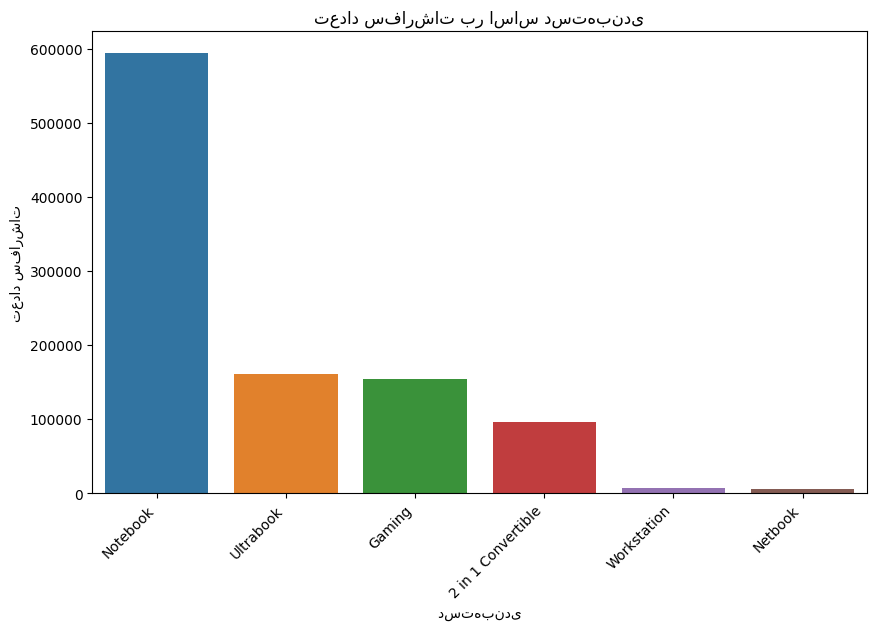

In [15]:
order_count_by_category = df_orders['category_name'].value_counts()
print('تعداد سفارشات بر اساس دسته‌بندی:')
print(order_count_by_category)

plt.figure(figsize=(10, 6))
sns.barplot(x=order_count_by_category.index, y=order_count_by_category.values)
plt.title('تعداد سفارشات بر اساس دسته‌بندی')
plt.xlabel('دسته‌بندی')
plt.ylabel('تعداد سفارشات')
plt.xticks(rotation=45, ha='right')  # چرخش نام دسته‌بندی‌ها
plt.show()

تعداد سفارشات بر اساس cpu_corei:
cpu_Corei
7    437272
5    393309
3     97428
0     90196
Name: count, dtype: int64


c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


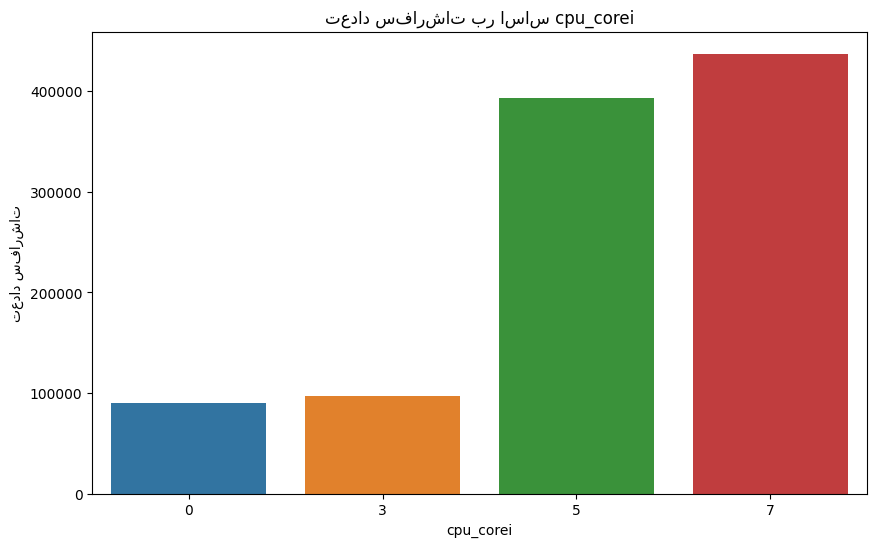

In [18]:
order_count_by_cpu_corei = df_orders['cpu_Corei'].value_counts()
print('تعداد سفارشات بر اساس cpu_corei:')
print(order_count_by_cpu_corei)

plt.figure(figsize=(10, 6))
sns.barplot(x=order_count_by_cpu_corei.index, y=order_count_by_cpu_corei.values)
plt.title('تعداد سفارشات بر اساس cpu_corei')
plt.xlabel('cpu_corei')
plt.ylabel('تعداد سفارشات')
plt.show()

تعداد سفارشات بر اساس cpu_brand:
cpu_brand
Intel      986965
AMD         30405
Samsung       835
Name: count, dtype: int64


c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


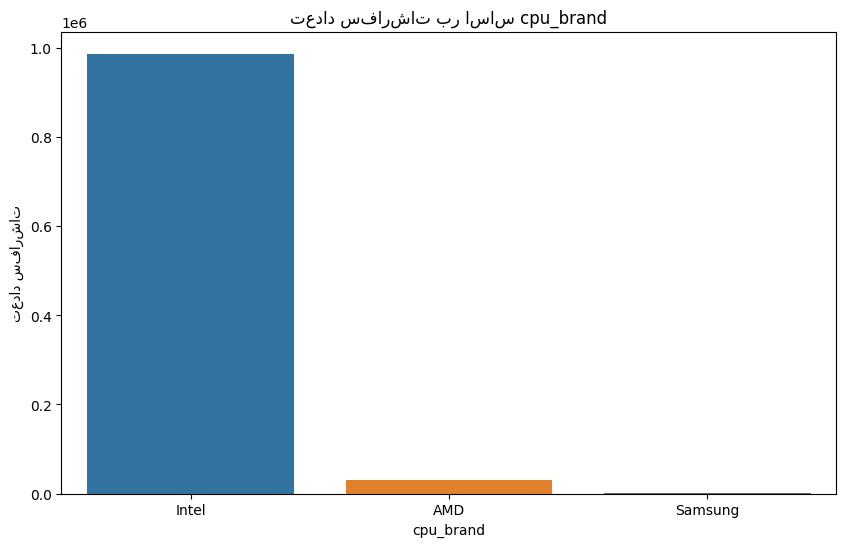

In [19]:
# تعداد سفارشات بر اساس cpu_brand
order_count_by_cpu_brand = df_orders['cpu_brand'].value_counts()
print('تعداد سفارشات بر اساس cpu_brand:')
print(order_count_by_cpu_brand)

# نمودار تعداد سفارشات بر اساس cpu_brand
plt.figure(figsize=(10, 6))
sns.barplot(x=order_count_by_cpu_brand.index, y=order_count_by_cpu_brand.values)
plt.title('تعداد سفارشات بر اساس cpu_brand')
plt.xlabel('cpu_brand')
plt.ylabel('تعداد سفارشات')
plt.show()

تعداد سفارشات بر اساس manufacturers:
manufacturers
Dell         261538
HP           225310
Lenovo       222454
Asus         115530
Acer          69968
Toshiba       43303
MSI           35287
Apple         17878
Xiaomi         5209
Microsoft      4681
Samsung        4606
Fujitsu        3333
Razer          2717
Google         1931
Huawei         1682
Mediacom       1089
LG              726
Chuwi           544
Vero            419
Name: count, dtype: int64


c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


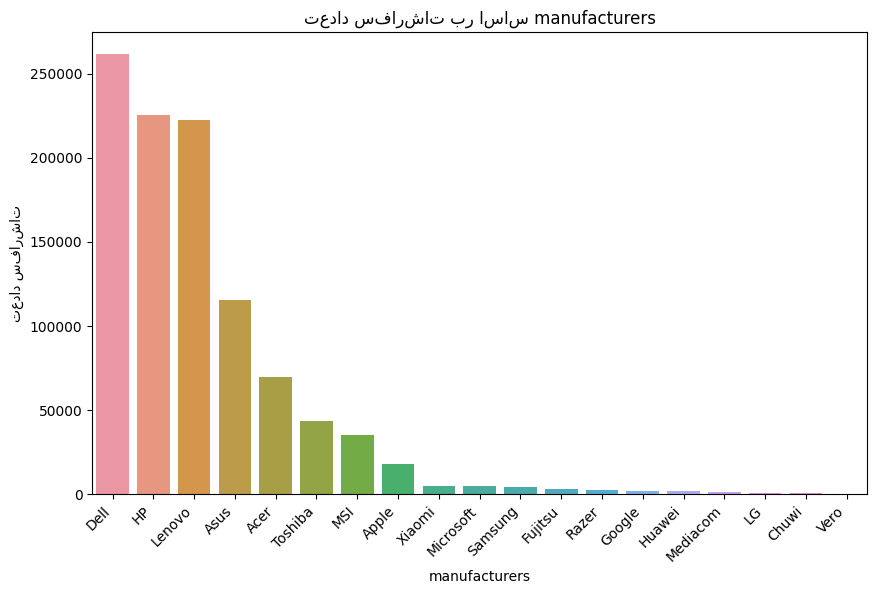

In [21]:
# تعداد سفارشات بر اساس manufacturers
order_count_by_manufacturers = df_orders['manufacturers'].value_counts()
print('تعداد سفارشات بر اساس manufacturers:')
print(order_count_by_manufacturers)

# نمودار تعداد سفارشات بر اساس manufacturers
plt.figure(figsize=(10, 6))
sns.barplot(x=order_count_by_manufacturers.index, y=order_count_by_manufacturers.values)
plt.title('تعداد سفارشات بر اساس manufacturers')
plt.xlabel('manufacturers')
plt.ylabel('تعداد سفارشات')
plt.xticks(rotation=45, ha='right')  # چرخش نام دسته‌بندی‌ها
plt.show()

تعداد سفارشات بر اساس screen_size:
screen_size
15.6    531328
14.0    158344
13.3    133054
17.3    120332
12.5     25482
11.6     15578
12.0      6751
15.0      6290
13.5      4681
13.9      4171
15.4      3605
12.3      3102
10.1      1935
13.0      1682
11.3      1179
17.0       501
14.1       114
18.4        76
Name: count, dtype: int64


c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


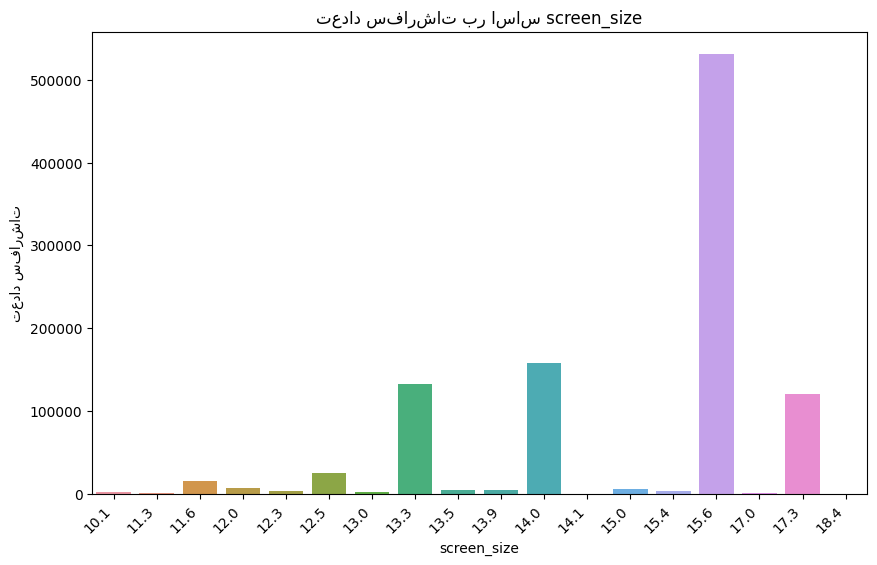

In [22]:
# تعداد سفارشات بر اساس screen_size
order_count_by_screen_size = df_orders['screen_size'].value_counts()
print('تعداد سفارشات بر اساس screen_size:')
print(order_count_by_screen_size)

# نمودار تعداد سفارشات بر اساس screen_size
plt.figure(figsize=(10, 6))
sns.barplot(x=order_count_by_screen_size.index, y=order_count_by_screen_size.values)
plt.title('تعداد سفارشات بر اساس screen_size')
plt.xlabel('screen_size')
plt.ylabel('تعداد سفارشات')
plt.xticks(rotation=45, ha='right')  # چرخش نام دسته‌بندی‌ها
plt.show()

تعداد سفارشات بر اساس screen_type:
ram
8     554032
4     286638
16    114132
6      36909
12     17328
2       4103
32      3765
24      1204
64        94
Name: count, dtype: int64


c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


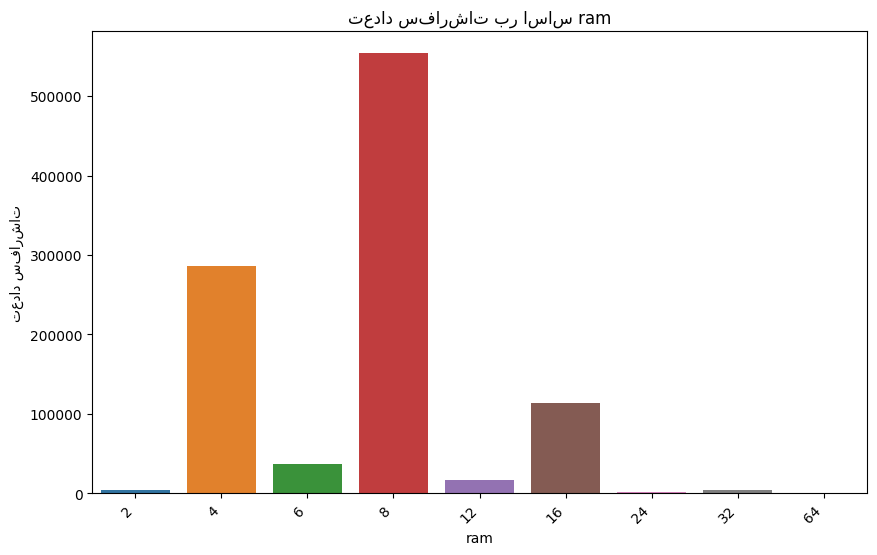

In [24]:
# تعداد سفارشات بر اساس ram
order_count_by_ram = df_orders['ram'].value_counts()
print('تعداد سفارشات بر اساس screen_type:')
print(order_count_by_ram)

# نمودار تعداد سفارشات بر اساس ram
plt.figure(figsize=(10, 6))
sns.barplot(x=order_count_by_ram.index, y=order_count_by_ram.values)
plt.title('تعداد سفارشات بر اساس ram')
plt.xlabel('ram')
plt.ylabel('تعداد سفارشات')
plt.xticks(rotation=45, ha='right')  # چرخش نام دسته‌بندی‌ها
plt.show()

c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


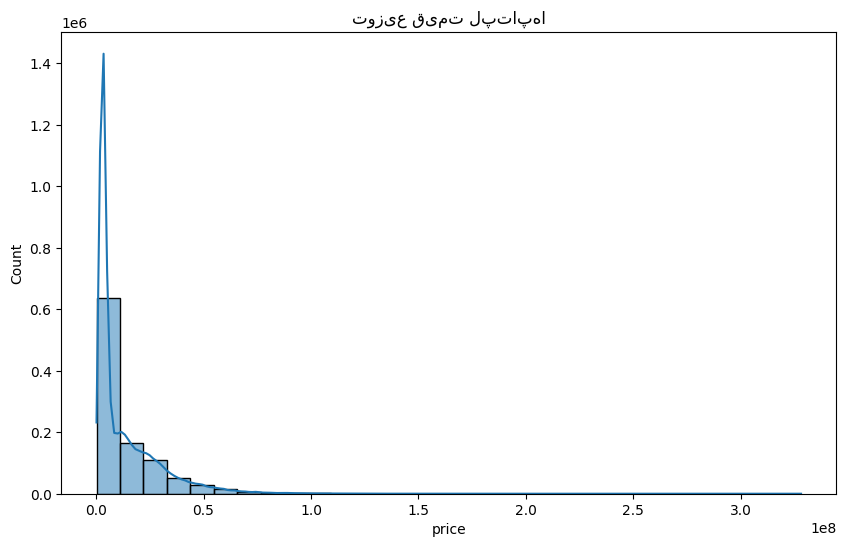

c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mehrd\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


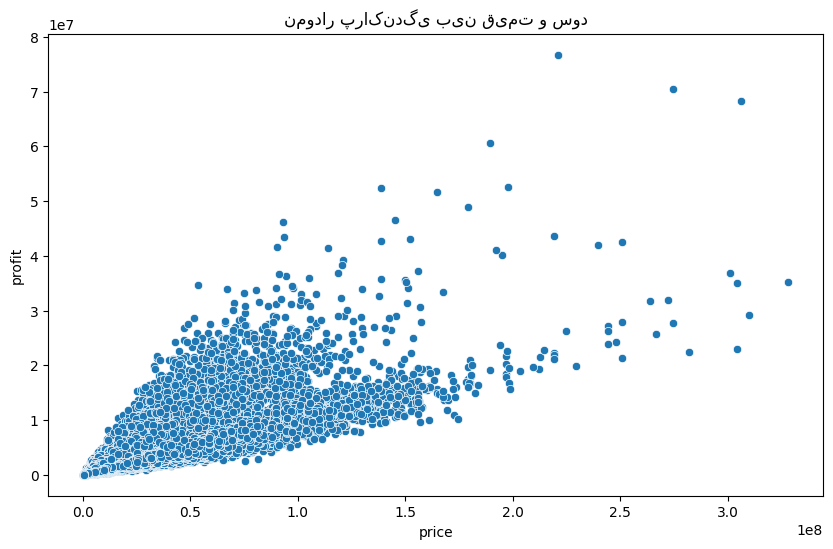

In [28]:
# نمودار توزیع قیمت
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['price'], bins=30, kde=True)
plt.title('توزیع قیمت لپ‌تاپ‌ها')
plt.show()

# نمودار پراکندگی بین قیمت و سود
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='profit', data=df_orders)
plt.title('نمودار پراکندگی بین قیمت و سود')
plt.show()

In [5]:
# محاسبه معیارها
category_name_metrics = df_orders.groupby('category_name').agg({
    'profit': 'mean',
    'price': 'sum',
    'quantity': 'sum'
})

cpu_Corei_metrics = df_orders.groupby('cpu_Corei').agg({
    'profit': 'mean',
    'price': 'sum',
    'quantity': 'sum'
})

cpu_brand_metrics = df_orders.groupby('cpu_brand').agg({
    'profit': 'mean',
    'price': 'sum',
    'quantity': 'sum'
})

manufacturers_metrics = df_orders.groupby('manufacturers').agg({
    'profit': 'mean',
    'price': 'sum',
    'quantity': 'sum'
})

screen_size_metrics = df_orders.groupby('screen_size').agg({
    'profit': 'mean',
    'price': 'sum',
    'quantity': 'sum'
})

ram_metrics = df_orders.groupby('ram').agg({
    'profit': 'mean',
    'price': 'sum',
    'quantity': 'sum'
})

# وزن‌دهی به معیارها (مثال)
weights = {
    'profit': 0.5,
    'price': 0.3,
    'quantity': 0.2
}

# محاسبه امتیازات بر اساس وزن‌دهی
category_name_scores = (category_name_metrics * weights).sum(axis=1)
cpu_Corei_scores     = (cpu_Corei_metrics * weights).sum(axis=1)
cpu_brand_scores     = (cpu_brand_metrics * weights).sum(axis=1)
manufacturers_scores = (manufacturers_metrics * weights).sum(axis=1)
screen_size_scores   = (screen_size_metrics * weights).sum(axis=1)
ram_scores           = (ram_metrics * weights).sum(axis=1)

# تخصیص سرمایه
total_capital = 1  # مجموع سرمایه (مثال)
category_name_capital_allocation = (category_name_scores / category_name_scores.sum()) * total_capital
cpu_Corei_capital_allocation     = (cpu_Corei_scores / cpu_Corei_scores.sum()) * total_capital
cpu_brand_capital_allocation     = (cpu_brand_scores / cpu_brand_scores.sum()) * total_capital
manufacturers_capital_allocation = (manufacturers_scores / manufacturers_scores.sum()) * total_capital
screen_size_capital_allocation   = (screen_size_scores / screen_size_scores.sum()) * total_capital
ram_capital_allocation           = (ram_scores / ram_scores.sum()) * total_capital

print("تخصیص سرمایه به category_name:")
print(category_name_capital_allocation)
category_name_df = pd.DataFrame({
    'index': category_name_capital_allocation.index,
    'value': category_name_capital_allocation.values
})
category_name_df.to_csv('4-category-name-chart.csv', index=False)

print("تخصیص سرمایه به cpu_Corei:")
print(cpu_Corei_capital_allocation)
cpu_Corei_df = pd.DataFrame({
    'index': cpu_Corei_capital_allocation.index,
    'value': cpu_Corei_capital_allocation.values
})
cpu_Corei_df.to_csv('4-cpu-corei-chart.csv', index=False)

print("تخصیص سرمایه به cpu_brand:")
print(cpu_brand_capital_allocation)
cpu_Corei_df = pd.DataFrame({
    'index': cpu_brand_capital_allocation.index,
    'value': cpu_brand_capital_allocation.values
})
cpu_Corei_df.to_csv('4-cpu-brand-chart.csv', index=False)

print("تخصیص سرمایه به manufacturers:")
print(manufacturers_capital_allocation)
manufacturers_df = pd.DataFrame({
    'index': manufacturers_capital_allocation.index,
    'value': manufacturers_capital_allocation.values
})
manufacturers_df.to_csv('4-manufacturers-chart.csv', index=False)

print("تخصیص سرمایه به screen_size:")
print(screen_size_capital_allocation)
screen_size_df = pd.DataFrame({
    'index': screen_size_capital_allocation.index,
    'value': screen_size_capital_allocation.values
})
screen_size_df.to_csv('4-screen-size-chart.csv', index=False)

print("تخصیص سرمایه به ram:")
print(ram_capital_allocation)
ram_df = pd.DataFrame({
    'index': ram_capital_allocation.index,
    'value': ram_capital_allocation.values
})
ram_df.to_csv('4-ram-chart.csv', index=False)

# ترسیم نمودار
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# نمودار میله‌ای برای تخصیص به برندها
category_name_capital_allocation.sort_values().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('تخصیص سرمایه به category_name')

# نمودار میله‌ای برای تخصیص به دسته‌بندی‌ها
cpu_Corei_capital_allocation.sort_values().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('تخصیص سرمایه به cpu_Corei')

cpu_brand_capital_allocation.sort_values().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('تخصیص سرمایه به cpu_brand')

manufacturers_capital_allocation.sort_values().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('تخصیص سرمایه به manufacturers')

screen_size_capital_allocation.sort_values().plot(kind='bar', ax=axes[2, 0])
axes[2, 0].set_title('تخصیص سرمایه به screen_size')

ram_capital_allocation.sort_values().plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_title('تخصیص سرمایه به ram')

# تنظیم فاصله بین نمودارها
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()


تخصیص سرمایه به category_name:
category_name
2 in 1 Convertible    0.102293
Gaming                0.185852
Netbook               0.003359
Notebook              0.499711
Ultrabook             0.195536
Workstation           0.013249
dtype: float64


In [51]:
mydb2 = mysql.connector.connect(
    host="localhost",
    user="root",
    password="3901",
    database="laptop_zoomit_new",
    auth_plugin='mysql_native_password'
)

In [52]:
query = """
SELECT product.title, product.model, product.price, manufacturer.name, screen_size.size, cpu.name, ram.name
FROM product
         INNER JOIN manufacturer on product.manufacturer_id = manufacturer.id
         inner join screen_size on product.screen_size_id = screen_size.id
         inner join cpu on product.cpu_id = cpu.id
         inner join ram on product.ram_id = ram.id
"""
mycursor = mydb.cursor()
mycursor.execute(query)
orders = mycursor.fetchall()
df_orders = pd.DataFrame(
    orders,
    columns=['title', 'model', 'price', 'manufacturer', 'screen_size', 'cpu', 'ram'])

تخصیص سرمایه به cpu:
cpu
AMD Ryzen 3 3250U        0.003811
AMD Ryzen 3 7320U        0.003255
AMD Ryzen 5 4600H        0.004745
AMD Ryzen 5 5600H        0.010477
AMD Ryzen 5 7530U        0.001781
                           ...   
اینتل Core i9-11900H     0.003781
اینتل Core i9-12900H     0.024423
اینتل Core i9-12900HX    0.007891
اینتل Core i9-13900H     0.012998
اینتل Pentium N6000      0.001477
Length: 61, dtype: float64
تخصیص سرمایه به ram:
ram
12 گیگابایت    0.053326
16 گیگابایت    0.494301
20 گیگابایت    0.020518
24 گیگابایت    0.050464
32 گیگابایت    0.175886
4 گیگابایت     0.011222
40 گیگابایت    0.023771
64 گیگابایت    0.012315
8 گیگابایت     0.158197
dtype: float64
تخصیص سرمایه به manufacturer:
manufacturer
ASUS      0.782420
HP        0.155436
HUAWEI    0.001205
MSI       0.060939
dtype: float64
تخصیص سرمایه به screen_size:
screen_size
13.3    0.014907
13.4    0.013120
13.5    0.007014
14.5    0.010739
15.6    0.769956
16.1    0.037490
17.3    0.146774
dtype: float64


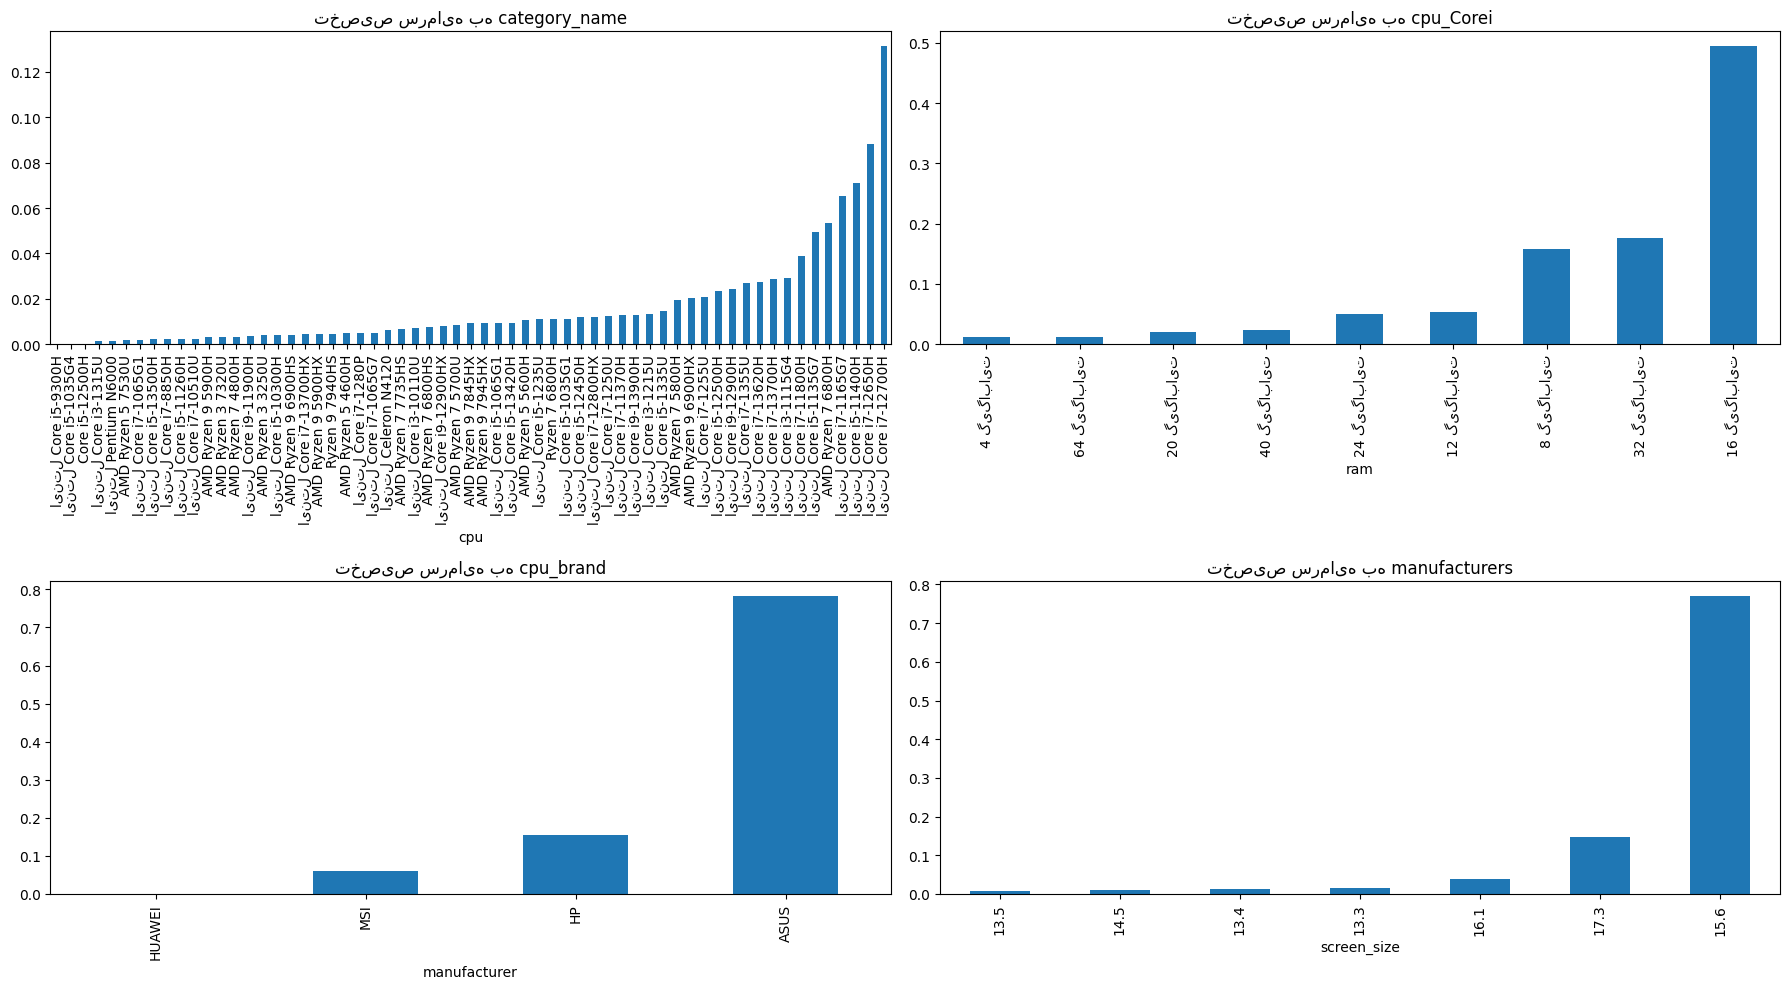

In [53]:
# محاسبه معیارها
cpu_metrics = df_orders.groupby('cpu').agg({
    'price': 'sum',
    'title': 'count'
})

ram_metrics = df_orders.groupby('ram').agg({
    'price': 'sum',
    'title': 'count'
})

manufacturer_metrics = df_orders.groupby('manufacturer').agg({
    'price': 'sum',
    'title': 'count'
})

screen_size_metrics = df_orders.groupby('screen_size').agg({
    'price': 'sum',
    'title': 'count'
})



# وزن‌دهی به معیارها (مثال)
weights = {
    'price': 0.3,
    'title': 0.7
}

# محاسبه امتیازات بر اساس وزن‌دهی
cpu_scores = (cpu_metrics * weights).sum(axis=1)
ram_scores     = (ram_metrics * weights).sum(axis=1)
manufacturer_scores     = (manufacturer_metrics * weights).sum(axis=1)
screen_size_scores = (screen_size_metrics * weights).sum(axis=1)

# تخصیص سرمایه
total_capital = 1  # مجموع سرمایه (مثال)
cpu_capital_allocation = (cpu_scores / cpu_scores.sum()) * total_capital
ram_capital_allocation     = (ram_scores / ram_scores.sum()) * total_capital
manufacturer_capital_allocation     = (manufacturer_scores / manufacturer_scores.sum()) * total_capital
screen_size_capital_allocation = (screen_size_scores / screen_size_scores.sum()) * total_capital

print("تخصیص سرمایه به cpu:")
print(cpu_capital_allocation)

print("تخصیص سرمایه به ram:")
print(ram_capital_allocation)

print("تخصیص سرمایه به manufacturer:")
print(manufacturer_capital_allocation)

print("تخصیص سرمایه به screen_size:")
print(screen_size_capital_allocation)

# ترسیم نمودار
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# نمودار میله‌ای برای تخصیص به برندها
cpu_capital_allocation.sort_values().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('تخصیص سرمایه به category_name')

# نمودار میله‌ای برای تخصیص به دسته‌بندی‌ها
ram_capital_allocation.sort_values().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('تخصیص سرمایه به cpu_Corei')

manufacturer_capital_allocation.sort_values().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('تخصیص سرمایه به cpu_brand')

screen_size_capital_allocation.sort_values().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('تخصیص سرمایه به manufacturers')

# تنظیم فاصله بین نمودارها
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()